## Import Required Libraries

In [1]:
from keras.models import load_model
import PIL
from PIL import Image
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize, rescale
import cv2
from matplotlib import image
from skimage import img_as_ubyte
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from scipy.ndimage.filters import gaussian_filter
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import tensorflow as tf
from sewar import uqi

In [2]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

## Initialize Class Names and Config for MRCNN

In [4]:
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [5]:
class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

## Data Generation Utility Functions

In [6]:
def folder_images(path):
    image_list = glob.glob(path)
    return image_list

def DataGenerator(rgb_list,input_shape,scale=50):
    while True:
        idx = random.randint(0,len(rgb_list))
        rgb = image.imread(rgb_list[idx])
        rgb = resize(rgb,tuple(input_shape[0:2]))
        width = int(rgb.shape[1] * scale / 100)
        height = int(rgb.shape[0] * scale / 100)
        dsize = (width, height)
        output = cv2.resize(rgb, dsize)
        output =  cv2.resize(output,(input_shape[0],input_shape[1]))
        yield np.asarray(img_as_ubyte(rgb)),np.asarray(img_as_ubyte(output))
        
def BatchDataGenerator(rgb_list,input_shape,scale=50,batch_size=5):
    while True:
        idx = random.sample(range(0,len(rgb_list)),batch_size)
        X_train = []
        y_train = []
        for i in idx:
            rgb = image.imread(rgb_list[i])
            rgb = resize(rgb,(input_shape[0],input_shape[1]))
            width = int(rgb.shape[1] * scale / 100)
            height = int(rgb.shape[0] * scale / 100)
            dsize = (width, height)
            output = cv2.resize(rgb, dsize)
            output =  cv2.resize(output,(input_shape[0],input_shape[1]))
            rgb = np.asarray(img_as_ubyte(rgb))
            output = np.asarray(img_as_ubyte(output))
            X_train.append(output)
            y_train.append(rgb)
        yield np.asarray(X_train),np.asarray(y_train)
            
def plot_predictions(X,Y,model):
    lr_img = X[0]
    hr_img = Y[0]
    prediction = np.uint8(model.predict(X)[0])
    print("SSIM between Original HR and Original HR: {}".format(structural_similarity(hr_img,hr_img,multichannel=True)))
    print("SSIM between Original LR and Original HR: {}".format(structural_similarity(lr_img,hr_img,multichannel=True)))
    print("SSIM between Original LR and Predicted HR: {}".format(structural_similarity(hr_img,prediction,multichannel=True)))
    print("PSNR between Original HR and Original HR: {}".format(peak_signal_noise_ratio(hr_img,hr_img)))
    print("PSNR between Original LR and Original HR: {}".format(peak_signal_noise_ratio(lr_img,hr_img)))
    print("PSNR between Original LR and Predicted HR: {}".format(peak_signal_noise_ratio(hr_img,prediction)))
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(lr_img)
    plt.subplot(1,3,2)
    plt.imshow(hr_img)
    plt.subplot(1,3,3)
    plt.imshow(prediction)

## Image Segmentation and Mask Functions

In [7]:
def masked_image(image,mask):
    img = image.copy()
    for i in range(img.shape[2]):
        img[:,:,i] = img[:,:,i]*mask
    return img

In [8]:
def region_mask(masks):
    initial_mask = np.zeros((masks.shape[0],masks.shape[1]))
    for i in range(masks.shape[2]):
        initial_mask = np.logical_or(initial_mask,masks[:,:,i])
    return initial_mask

In [9]:
def complete_masked_image(image,masks,single=None):
    initial_image = np.zeros_like(image)
    if single==None:
        for i in range(masks.shape[2]):
            initial_image+=masked_image(image,masks[:,:,i])
    else:
        initial_image+=masked_image(image,masks[:,:,single])
    return initial_image

## Evaluation Metric Functions for Input Output Pairs

In [10]:
def compare_ssim(X,Y,Z):
    print("SSIM between Original HR and Original HR: {}".format(structural_similarity(Y,Y,multichannel=True)))
    print("SSIM between Original HR and Original LR: {}".format(structural_similarity(Y,X,multichannel=True)))
    print("SSIM between Original HR and Predicted HR: {}".format(structural_similarity(Y,Z,multichannel=True)))

In [11]:
def compare_psnr(X,Y,Z):
    print("PSNR between Original HR and Original HR: {}".format(peak_signal_noise_ratio(Y,Y)))
    print("PSNR between Original HR and Original LR: {}".format(peak_signal_noise_ratio(Y,X)))
    print("PSNR between Original HR and Predicted HR: {}".format(peak_signal_noise_ratio(Y,Z)))

In [12]:
def compare_uqi(X,Y,Z):
    print("UQI between Original HR and Original HR: {}".format(uqi(Y,Y)))
    print("UQI between Original HR and Original LR: {}".format(uqi(Y,X)))
    print("UQI between Original HR and Predicted HR: {}".format(uqi(Y,Z)))

In [13]:
def compare_image_ssim(img,percent=False):
    rgb = image.imread(img)
    rgb = resize(rgb,(input_shape[0],input_shape[1]))
    width = int(rgb.shape[1] * scale / 100)
    height = int(rgb.shape[0] * scale / 100)
    dsize = (width, height)
    output = cv2.resize(rgb, dsize)
    output =  cv2.resize(output,(input_shape[0],input_shape[1]))
    rgb = np.asarray(img_as_ubyte(rgb))
    output = np.asarray(img_as_ubyte(output))
    testimg=tf.expand_dims(output, axis=0)
    testsr=SuperRes.predict(testimg)
    testout=tf.keras.backend.squeeze(testsr, axis=0)
    final=testout.numpy()
    final=final.astype(int)
    return structural_similarity(rgb,output,multichannel=True),structural_similarity(rgb,final,multichannel=True)

In [14]:
def get_change(current, previous):
    if current == previous:
        return 0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return float('inf')

In [15]:
def average_ssim_quality_increase(valid_list):
    ssim_list = []
    for valid in valid_list:
        orig,res = compare_image_ssim(valid)
        ssim_list.append(get_change(res,orig))
    return np.mean(ssim_list)

In [16]:
def average_psnr_quality_increase(valid_list):
    ssim_list = []
    for valid in valid_list:
        orig,res = compare_image_psnr(valid)
        ssim_list.append(get_change(res,orig))
    return np.mean(ssim_list)

In [17]:
def compare_image_psnr(img):
    rgb = image.imread(img)
    rgb = resize(rgb,(input_shape[0],input_shape[1]))
    width = int(rgb.shape[1] * scale / 100)
    height = int(rgb.shape[0] * scale / 100)
    dsize = (width, height)
    output = cv2.resize(rgb, dsize)
    output =  cv2.resize(output,(input_shape[0],input_shape[1]))
    rgb = np.asarray(img_as_ubyte(rgb))
    output = np.asarray(img_as_ubyte(output))
    testimg=tf.expand_dims(output, axis=0)
    testsr=SuperRes.predict(testimg)
    testout=tf.keras.backend.squeeze(testsr, axis=0)
    final=testout.numpy()
    final=final.astype(int)
    return peak_signal_noise_ratio(rgb,output),peak_signal_noise_ratio(rgb,final)

In [18]:
def compare_image_uqi(img):
    rgb = image.imread(img)
    rgb = resize(rgb,(input_shape[0],input_shape[1]))
    width = int(rgb.shape[1] * scale / 100)
    height = int(rgb.shape[0] * scale / 100)
    dsize = (width, height)
    output = cv2.resize(rgb, dsize)
    output =  cv2.resize(output,(input_shape[0],input_shape[1]))
    rgb = np.asarray(img_as_ubyte(rgb))
    output = np.asarray(img_as_ubyte(output))
    testimg=tf.expand_dims(output, axis=0)
    testsr=SuperRes.predict(testimg)
    testout=tf.keras.backend.squeeze(testsr, axis=0)
    final=testout.numpy()
    final=final.astype(int)
    return uqi(rgb,output),uqi(rgb,final)

## Initialize MRCNN Model

In [19]:
mr_model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

Instructions for updating:
Use fn_output_signature instead


In [20]:
mr_model.load_weights(filepath="../mask_rcnn_coco.h5", by_name=True)

## Load Super Resolution Model

In [21]:
SuperRes=load_model('../srbestmodel.h5')

In [22]:
valid_hr = folder_images("../../data/DIV2K_valid_HR/DIV2K_valid_HR/*.png")

In [23]:
input_shape = (256, 256, 3)
scale = 50

In [24]:
def compare_masked_superres(X,Y,model,single=None):
    r = mr_model.detect([X[0]], verbose=0)
    r = r[0]
    masks = r['masks'].astype(int)
    mr_out = complete_masked_image(X[0],masks,single=single)
    testimg=tf.expand_dims(mr_out, axis=0)
    testsr=model.predict(testimg)
    testout=tf.keras.backend.squeeze(testsr, axis=0)
    final=testout.numpy()
    final=final.astype(int)
    Z = (X[0]-mr_out)+final
    compare_ssim(X[0],Y[0],Z)
    compare_psnr(X[0],Y[0],Z)
    compare_uqi(X[0],Y[0],Z)
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(X[0])
    plt.subplot(1,4,2)
    plt.imshow(Y[0])
    plt.subplot(1,4,3)
    plt.imshow(mr_out)
    plt.subplot(1,4,4)
    plt.imshow(Z)

In [25]:
X,Y = next(BatchDataGenerator(valid_hr,input_shape=input_shape,scale=scale,batch_size=1))

In [29]:
def average_uqi_quality_increase(valid_list):
    ssim_list = []
    for valid in valid_list:
        orig,res = compare_image_uqi(valid)
        ssim_list.append(get_change(res,orig))
    return np.mean(ssim_list)

## Base Super Resolution Evaluation on LR/SR Pairs

In [30]:
uqiv = average_uqi_quality_increase(valid_hr)

In [31]:
psnr = average_psnr_quality_increase(valid_hr)

In [32]:
ssim = average_ssim_quality_increase(valid_hr)

In [33]:
x=["ssim","psnr","uqi"]
y=[ssim,psnr,uqiv]

In [35]:
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(x,y,width=0.4,color=['red', 'green', 'blue'])
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.yticks(ticks=np.arange(0, 10, step=0.5))
for index,data in enumerate(y):
    plt.text(x=index-0.2 , y =data+0.1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.tight_layout()
plt.show()

## Sample Foreground Images

In [37]:
fore_hr = ['../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0805.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0809.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0829.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0862.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0855.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0894.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0886.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0882.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0863.png',
           '../../data/DIV2K_valid_HR/DIV2K_valid_HR\\0844.png'
          ]

## Function to Compare Sample Image Inference

In [38]:
def compare_fore_metrics(img,model=SuperRes,single=None):
    rgb = image.imread(img)
    rgb = resize(rgb,(input_shape[0],input_shape[1]))
    width = int(rgb.shape[1] * scale / 100)
    height = int(rgb.shape[0] * scale / 100)
    dsize = (width, height)
    output = cv2.resize(rgb, dsize)
    output =  cv2.resize(output,(input_shape[0],input_shape[1]))
    rgb = np.asarray(img_as_ubyte(rgb))
    output = np.asarray(img_as_ubyte(output))
    r = mr_model.detect([output], verbose=0)
    r = r[0]
    masks = r['masks'].astype(int)
    mr_out = complete_masked_image(output,masks,single=single)
    testimg=tf.expand_dims(mr_out, axis=0)
    testsr=model.predict(testimg)
    testout=tf.keras.backend.squeeze(testsr, axis=0)
    final=testout.numpy()
    final=final.astype(int)
    Z = (output-mr_out)+final
    compare_ssim(output,rgb,Z)
    print("-----------------------------------")
    compare_psnr(output,rgb,Z)
    print("-----------------------------------")
    compare_uqi(output,rgb,Z)
    print("-----------------------------------")
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(output)
    plt.subplot(1,4,2)
    plt.imshow(rgb)
    plt.subplot(1,4,3)
    plt.imshow(mr_out)
    plt.subplot(1,4,4)
    plt.imshow(Z)

## Sample Image

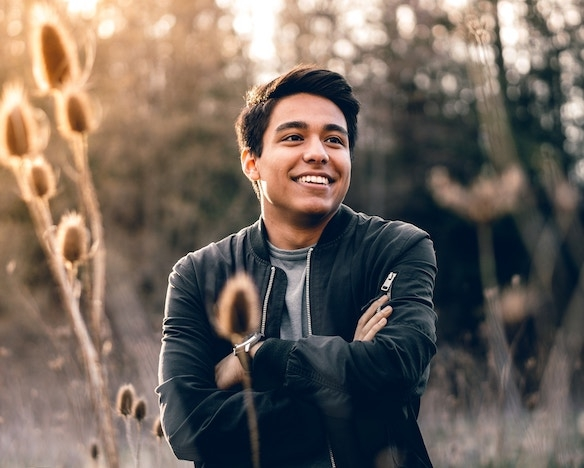

In [53]:
idx_path = "./samples/sr_7.jpg"
img = Image.open(idx_path)
img

In [54]:
img = np.asarray(img)
r = mr_model.detect([img], verbose=0)
r = r[0]

## MRCNN Inference

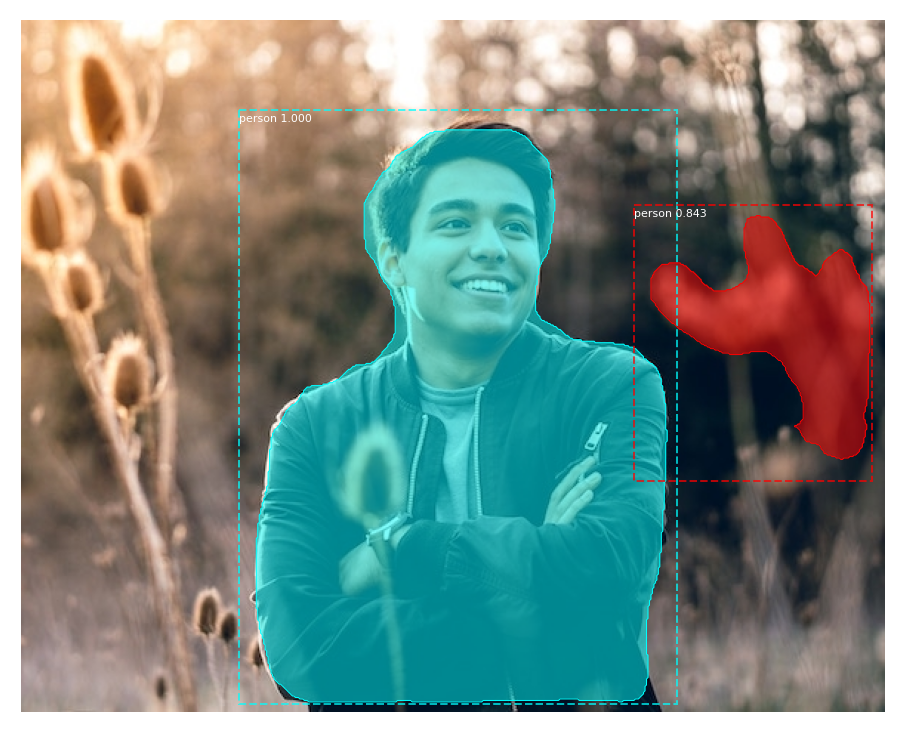

In [55]:
mrcnn.visualize.display_instances(image=img, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

## Super Resolution with MRCNN Inference

C:\Users\umash\AppData\Local\Temp/ipykernel_16804/3962057874.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  print("PSNR between Original HR and Predicted HR: {}".format(peak_signal_noise_ratio(Y,Z)))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM between Original HR and Original HR: 1.0
SSIM between Original HR and Original LR: 0.9385063852671723
SSIM between Original HR and Predicted HR: 0.9418252356289565
-----------------------------------
PSNR between Original HR and Original HR: inf
PSNR between Original HR and Original LR: 29.46267522920381
PSNR between Original HR and Predicted HR: 28.71563853270694
-----------------------------------
UQI between Original HR and Original HR: 1.0
UQI between Original HR and Original LR: 0.9864114093888899
UQI between Original HR and Predicted HR: 0.9847875186711872
-----------------------------------


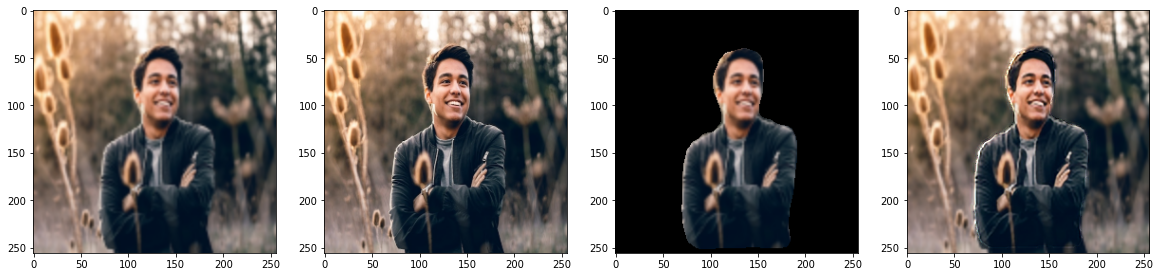

In [56]:
compare_fore_metrics(idx_path,single=0)